In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from bbl_utils import *
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

In [6]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

In [7]:
dx = 500.
delta_t = 60.
diter = 28800

iter0 = 3182400
Niter = 22
dt = 1728000

iters = np.arange(iter0, iter0 + diter*Niter, diter)

In [8]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_rest-tracer/run/"
ds = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag", "tracer01Diag", "tracer02Diag"], delta_t=60.)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [9]:
extend_multiples = [-6, 1]
xslice = [-1e6,1.5e6]
xslice = [-np.inf,np.inf]

Lx = ds['XC'].size*dx
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds = ds.sel(XC=slice(*xslice), XG=slice(*xslice))
H = ds['Depth'].max().values.copy().astype('>f8')
ds, grid = preprocess(ds, θ)
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

In [10]:
ds = ds.chunk({'XC': 400, 'XG': 400})

In [11]:
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['THETA_BG_U'] = Γ*ds['Zr_U']
ds['THETA_BG_V'] = Γ*ds['Zr_V']
ds['THETA_BG_W'] = Γ*ds['Zr_W']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']
ds['θ'] = ds['θ'].where(ds['hFacC'] != 0)

In [12]:
dθ = 0.1
θlevs = np.arange(0.-1*dθ, 1.+2*dθ, dθ)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xarray/plot/plot.py:906: UserWarning: The following kwargs were not used by contour: 'lw'
  primitive = ax.contour(x, y, z, **kwargs)


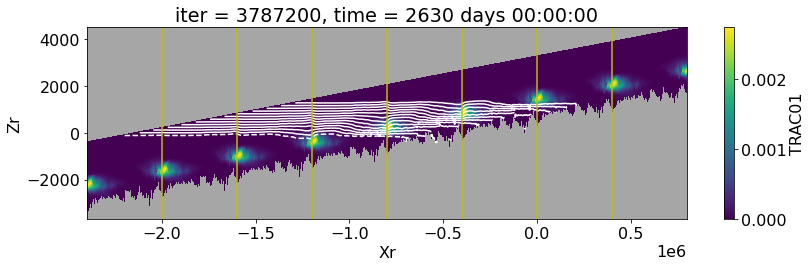

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,1,1, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).mean(dim='YC').plot(x='Xr', y='Zr')
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).mean(dim='YC').plot.contour(x='Xr', y='Zr', levels=θlevs, colors='w', lw=0.75)
plt.tight_layout()
#plt.ylim([-500, 1500])

for i in range(*extend_multiples):
    plt.axvline(x=(i+1)*(800*500), alpha=1, linestyle="-", color="y")

## Temperature budget

In [49]:
day2seconds = 1./(86400.)
tmp = tracer_flux_budget(ds, grid, '_TH', Γ = Γ, θ = θ).chunk({'Z': -1, 'YC': -1, 'XC': 400})
tmp['total_tendency_TH'] = tmp['conv_total_flux_TH'].fillna(0.)
tmp['total_tendency_TH_truth'] = ds.TOTTTEND * ds['dV'] * day2seconds
tmp['diff_tendency_TH'] = tmp['conv_horiz_diff_flux_TH'] + tmp['conv_vert_diff_flux_TH'] + tmp['conv_vert_diff_flux_anom_TH']
tmp['adv_tendency_TH'] = tmp['conv_horiz_adv_flux_TH'] + tmp['conv_vert_adv_flux_TH'] + tmp['conv_adv_flux_anom_TH']

ds = xr.merge([ds, tmp])

In [55]:
h = histogram(ds['θ'], bins=[θlevs], weights=ds['diff_tendency_TH']).compute()

In [101]:
dθ = 0.05
θlevs = np.arange(0.-dθ, 1.+dθ, dθ)

T = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=-ds['diff_tendency_TH'].where(~np.isnan(ds['diff_tendency_TH']), 0.),
    dim=('XC', 'YC', 'Z',)
).compute()/dθ

<xarray.DataArray 'histogram_θ' (time: 22, θ_bin: 21)>
array([[-1026.29126393, -1069.96635001, -1106.0653479 , -1074.89614379,
        -1042.03083927, -1261.41523207, -1387.65117084, -1381.7468353 ,
        -1245.95825048, -1193.06556485, -1071.3462689 ,  -993.7959413 ,
        -1124.95137736, -1141.52304219,  -993.26142696, -1123.85137073,
        -1391.83654125, -1387.61089339, -1304.3243917 , -1230.14926177,
        -1142.16748946],
       [-1001.30647387,  -915.09504297,  -939.78689935, -1073.91923419,
        -1161.78240043, -1298.54721972, -1315.10816558, -1295.24230502,
        -1123.25880613, -1165.10387166, -1066.94276333,  -939.63454292,
         -919.56997763, -1003.84139638, -1062.24641562, -1290.02282972,
        -1327.42426906, -1296.13737998, -1234.51951229, -1118.68544466,
        -1127.47795599],
       [ -969.03106122, -1082.51082545, -1137.41119561, -1076.45777982,
        -1209.80157247, -1355.11872917, -1262.57217045, -1230.11258897,
        -1110.42837637, -1026.68811605,  -936.04812805, -1019.53537353,
        -1082.16777074, -1155.84508835, -1077.68079575, -1323.07137821,
        -1352.57225805, -1230.97952896, -1158.28081606, -1105.09851129,
         -965.58298236],
       [-1090.47537662, -1138.52091269, -1098.84596501, -1104.92884106,
        -1176.00122643, -1265.50263592, -1260.99059597, -1298.89765459,
        -1246.89392987, -1055.74200884, -1052.45571136, -1125.75120559,
        -1084.32504187, -1142.14477891, -1123.81034428, -1221.65096018,
        -1263.65294798, -1283.74596598, -1313.570624  , -1119.48187899,
        -1073.32908401],
       [ -908.97590047,  -956.15989148, -1179.49609808, -1264.3799546 ,
        -1176.06381685, -1237.14256675, -1358.27692104, -1299.60578061,
        -1152.86825428,  -999.25510119,  -917.26404507,  -878.97828436,
        -1063.77307696, -1266.02027606, -1247.51488775, -1163.28956156,
        -1363.87419831, -1327.05355903, -1212.90759567, -1093.43031945,
         -927.46839701],
       [-1015.80806147, -1159.57943913, -1174.57388627, -1232.64908928,
        -1236.91235637, -1289.44019344, -1314.91002224, -1327.139569  ,
        -1230.37979905, -1061.8091299 ,  -994.25143125, -1034.24625051,
        -1163.51966264, -1234.57905031, -1212.93691865, -1307.227872  ,
        -1287.35953515, -1338.21535851, -1238.94961039, -1203.66330931,
         -994.9369523 ],
       [-1035.15458639,  -898.47194308,  -871.45899503, -1226.61112118,
        -1424.06401203, -1304.7993054 , -1311.82525676, -1255.42010885,
        -1199.36240576, -1146.56244733, -1007.82453845, -1002.34549877,
         -750.49410978, -1105.86784355, -1315.3885669 , -1437.91699032,
        -1292.81141703, -1249.70095473, -1219.72120859, -1165.16950924,
        -1116.36669569],
       [-1315.78722506, -1393.40306792, -1178.83473137, -1126.03156143,
        -1183.61827547, -1359.22738315, -1161.20266725, -1175.58124166,
        -1273.56287145,  -983.3479006 , -1178.00294005, -1379.49223666,
        -1309.47695287, -1153.82615188, -1126.91908466, -1301.20514227,
        -1287.143432  , -1178.52928319, -1200.62232766, -1142.17951257,
        -1016.81758963],
       [-1002.19998376,  -930.36326011, -1189.53588498, -1202.92772209,
        -1326.7734957 , -1202.7557241 , -1282.58654868, -1285.1955176 ,
        -1091.90962303, -1024.00347606,  -987.74025034,  -896.29645517,
        -1047.59744688, -1241.40963749, -1268.43816693, -1243.66935678,
        -1267.2250856 , -1312.38733486, -1175.9093018 , -1066.08305759,
         -950.82878101],
       [ -765.55556471,  -953.92008653, -1139.2023743 , -1205.02001951,
        -1393.89942568, -1555.61961974, -1229.85094082, -1328.37910954,
        -1256.95413414, -1095.56925713,  -789.25450118,  -771.55860374,
        -1093.06483909, -1164.85833519, -1236.07129043, -1555.95338631,
        -1432.84627867, -1242.93728969, -1306.56315017, -1213.1375609 ,
         -945.40904229],
       [-1112.68729791, -1122.87183664, -1107.41594196, -1300.71641675,
        -1318.1278166 ,

In [109]:
transformation = h/dθ

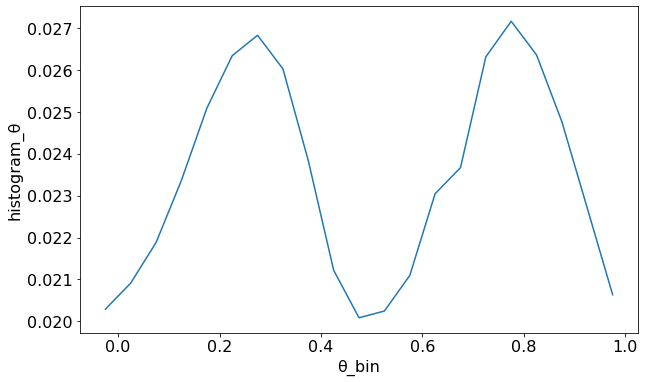

In [114]:
(-transformation*1e-6).mean(dim='time').plot()

In [131]:
inty = ds['diff_tendency_TH'].sel(XC=slice(-5e5, 2.5e5)).sum(dim='YC').isel(time=-1).compute()


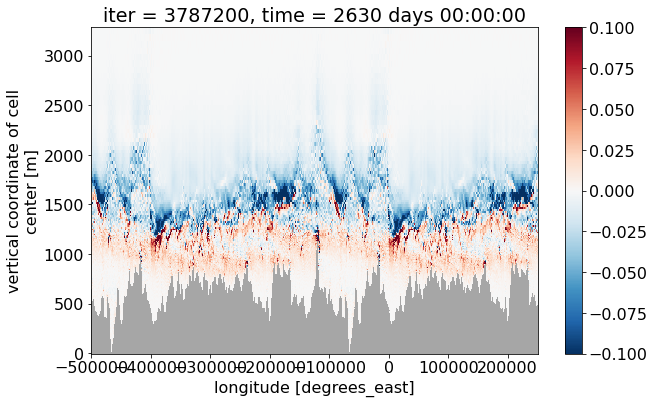

In [135]:
inty = inty.where(inty!=0, np.nan)
q = (inty/ds['drF']).plot()
q.set_clim([-0.1, 0.1])

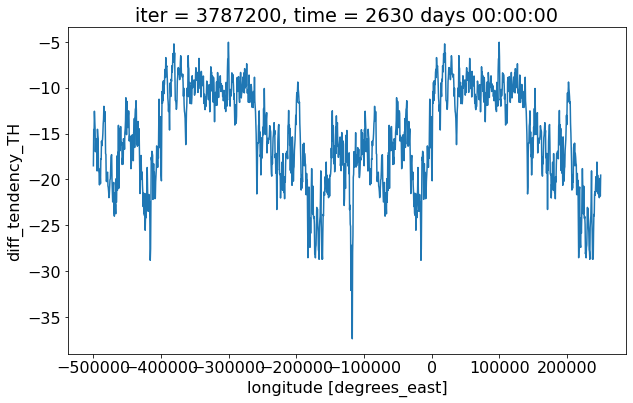

In [137]:
q = inty.sum(dim='Z', skipna=True).plot()

TypeError: Cannot cast scalar from dtype('float64') to dtype('<m8[ns]') according to the rule 'same_kind'

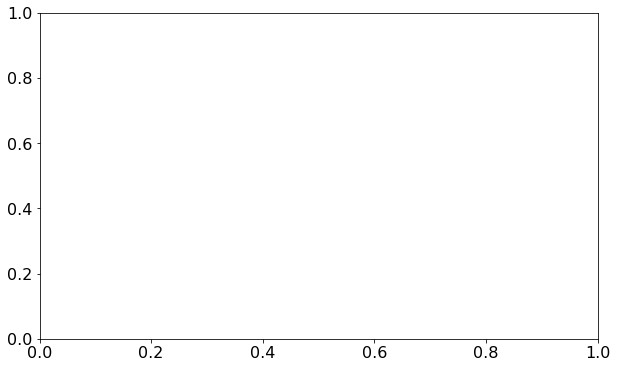

In [139]:
h.plot(y = "θ_bin", color="C0", linestyle="-")

## Watermass Transformation

In [ ]:
formation = np.zeros((θlevs.size, 3))
for k, θlev in enumerate(θlevs):
    print(k, end=", ")
    formation[k, 0] = TH['diff_tendency_TH'].where((ds['θ'] < θlev)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values
    formation[k, 1] = TH['diff_tendency_TH'].where((ds['θ'] < θlev) | (TH['diff_tendency_TH'] >= 0.)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values
    formation[k, 2] = TH['diff_tendency_TH'].where((ds['θ'] < θlev) | (TH['diff_tendency_TH'] <= 0.)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values

transformation = -np.diff(formation, axis=0)/dθ

0, 

In [ ]:
formation_adv = np.zeros(θlevs.size)
for k, θlev in enumerate(θlevs):
    print(k, end=", ")
    formation_adv[k] = TH['adv_tendency_TH'].where((ds['θ'] < θlev)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values
    
transformation_adv = -np.diff(formation_adv)/dθ

formation_dbdt = np.zeros(θlevs.size)
for k, θlev in enumerate(θlevs):
    print(k, end=", ")
    formation_dbdt[k] = TH['total_tendency_TH_truth'].where((ds['θ'] < θlev)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values

transformation_dbdt = -np.diff(formation_dbdt)/dθ

In [ ]:
θlevs_f = 0.5*(θlevs[1:] + θlevs[0:-1])
labels = ['Net', 'BBL', 'SML']
colors = ['k', 'C3', 'C0']

plt.figure(figsize=(6,8))
for i in range(3):
    plt.plot(transformation[:,i]*1.e-3, θlevs_f, label=labels[i], color=colors[i], lw=2.)

plt.plot(transformation_dbdt[:]*1.e-3, θlevs_f, color="C1", lw=1., label="Tendency")
plt.plot(transformation_adv[:]*1.e-3, θlevs_f, color="C2", lw=1., label="Advection")
    
Tinf = 5.2e-5 * np.tan(θ)**(-1) * 120 * 500
plt.axvline(x=Tinf*1.e-3, alpha=0.8, linestyle=":", color="k")
plt.grid(True)
plt.legend()
plt.xlabel("watermass transformation (mSv)")
plt.ylabel(r"$\Theta$ [$\degree$C]")
plt.xlim([-100, 100])
plt.ylim([0., 1.])